In [37]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import corr
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split

spark = SparkSession.builder.appName("YourAppName").getOrCreate()

Q1) The objective in this data set is to predict the median house value in a given district based on the values of the other features.

In [38]:
df = spark.read.csv("housing.csv", header=True, inferSchema=True)
df.printSchema()


root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [39]:
df.head()


Row(longitude=-122.23, latitude=37.88, housing_median_age=41.0, total_rooms=880.0, total_bedrooms=129.0, population=322.0, households=126.0, median_income=8.3252, median_house_value=452600.0, ocean_proximity='NEAR BAY')

In [40]:
display(df)

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string]

Answer 1.1:
The data type of each feature is:

- longitude: Ratio (it has a meaningful zero and consistent intervals)
- latitude: Ratio (similar reasoning as longitude)
- housing_median_age: Ratio (it has a true zero, e.g., 0 years old means no age)
- total_rooms: Ratio (0 rooms means no rooms)
- total_bedrooms: Ratio (0 bedrooms means no bedrooms)
- population: Ratio (0 population means no people)
- households: Ratio (0 households means no households)
- median_income: Ratio (0 income means no income)
- median_house_value: Ratio (House will not be free so median will not be 0)
- ocean_proximity: Nominal (No specific order)


In [41]:
summary_stats = df.describe()
summary_stats.show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

Answer 1.2
Display summary statistics of the data. What can you learn from it on the data?
- Total bedrooms is the only column that is incomplete and has null values, It could be imputed for future use
- Houses range from brand new to quite old, in the range of 1 yr to 52 years, with the median being on a slightly older side of 28.6
- The average median income is approximately $38,700, with a minimum of $4,999 and a maximum of $150,001
- The average house value is about $206,855.82, with the lowest being $14,999 and the highest limited to $500,001. The limit of $500,001 might indicate that values above this were grouped into this category
- Ocean proximity is nominal so doesnt have any summary statistics

In [42]:
target_column = "median_house_value"

correlations = []

for column in df.columns:
    if column != target_column and df.schema[column].dataType != StringType():
        correlation = df.stat.corr(target_column, column)
        correlations.append((column, correlation))

correlation_df = spark.createDataFrame(correlations, ["Feature", "Correlation"])

correlation_df.show()


+------------------+--------------------+
|           Feature|         Correlation|
+------------------+--------------------+
|         longitude|-0.04596661511798...|
|          latitude|-0.14416027687465752|
|housing_median_age| 0.10562341249321067|
|       total_rooms| 0.13415311380656275|
|    total_bedrooms| 0.04914821959942553|
|        population|-0.02464967888889...|
|        households| 0.06584265057005637|
|     median_income|  0.6880752079585578|
+------------------+--------------------+



Answer 1.3
- Median income is the only variable that is stongly corelated to the median house value, showing 68% correlation
- The next closest variables are Latitude and Total number of rooms, but they are weakly correlated
- None of the other variables show any strong correlation

/Users/karan_mudaliar/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/Users/karan_mudaliar/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


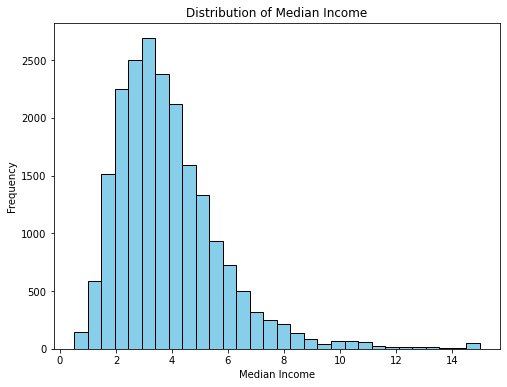

In [43]:
pandas_df = df.toPandas()
import matplotlib.pyplot as plt

# Histogram for median_income
plt.figure(figsize=(8, 6))
plt.hist(pandas_df['median_income'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.title('Distribution of Median Income')
plt.show()

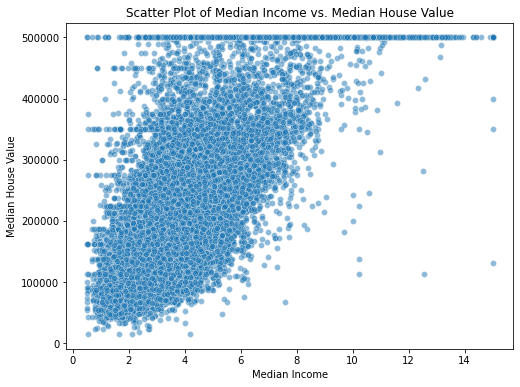

In [44]:
import seaborn as sns

# Scatter plot for median_income vs. median_house_value
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pandas_df, x='median_income', y='median_house_value', alpha=0.5)
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.title('Scatter Plot of Median Income vs. Median House Value')
plt.show()

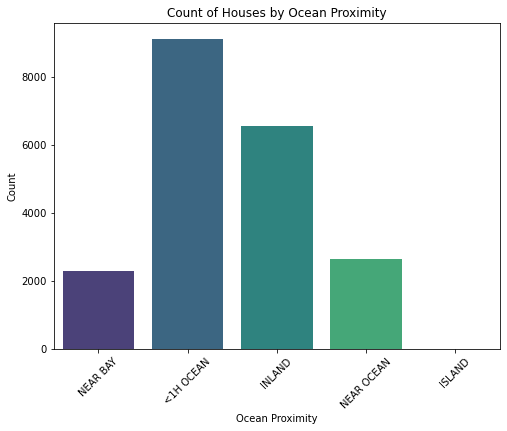

In [45]:
# Countplot for ocean_proximity
plt.figure(figsize=(8, 6))
sns.countplot(data=pandas_df, x='ocean_proximity', palette='viridis')
plt.xlabel('Ocean Proximity')
plt.ylabel('Count')
plt.title('Count of Houses by Ocean Proximity')
plt.xticks(rotation=45)
plt.show()


Answer 1.4


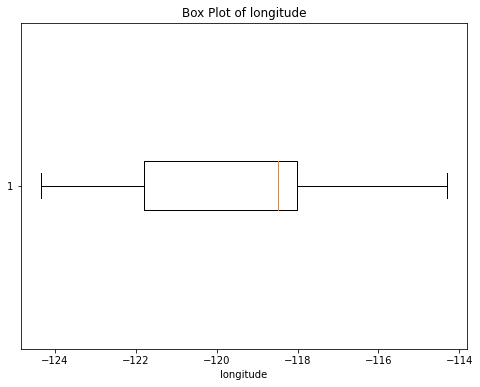

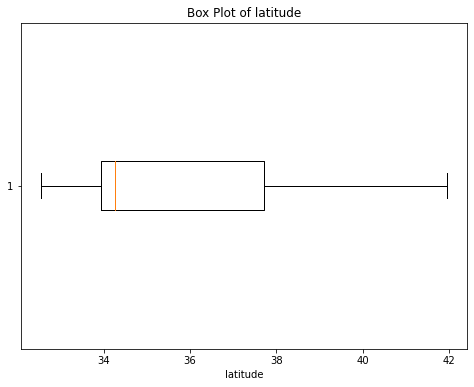

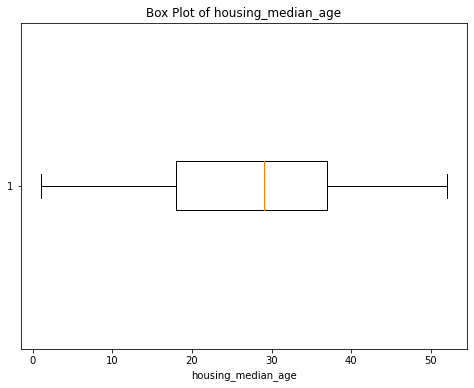

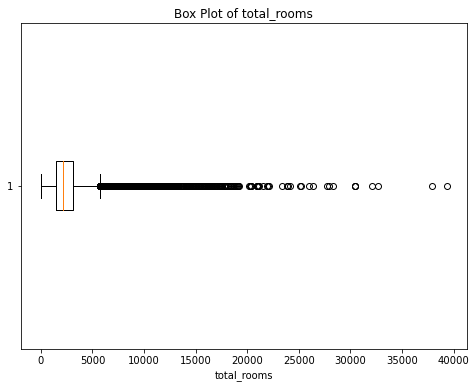

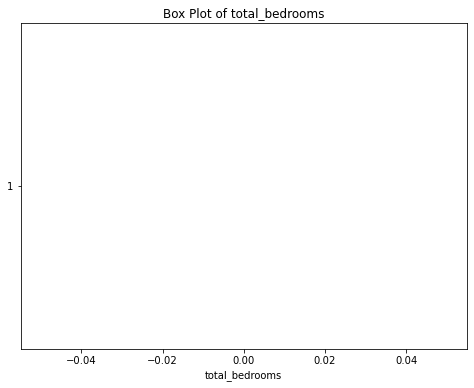

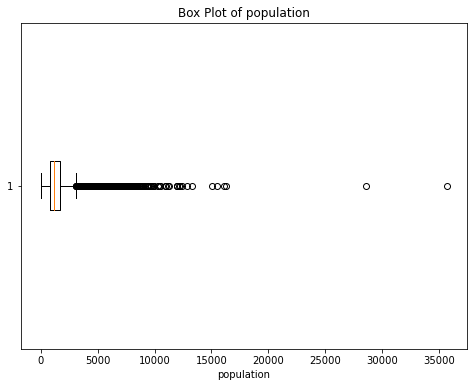

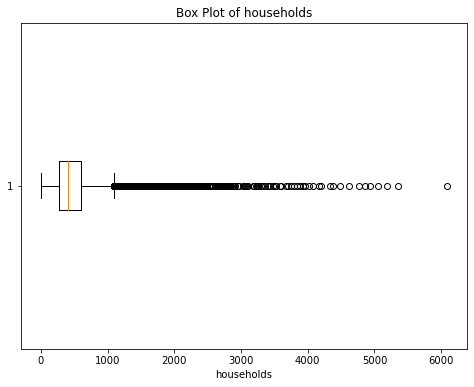

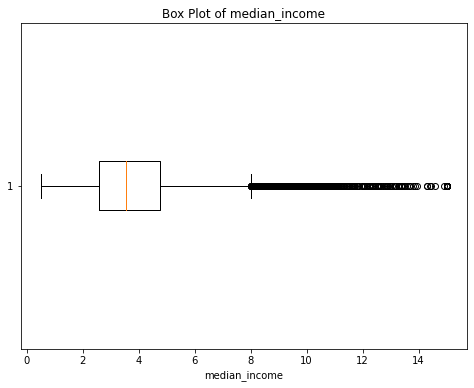

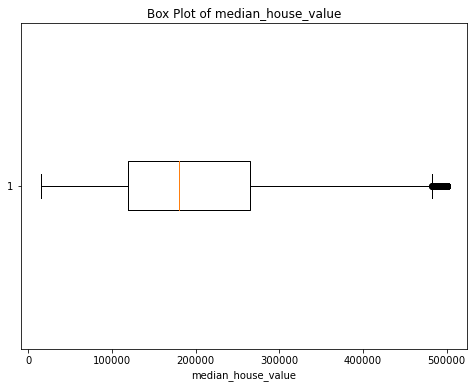

In [46]:
numeric_columns = pandas_df.select_dtypes(include=['number'])

# Create box plots for all numeric features
for column in numeric_columns.columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(pandas_df[column], vert=False)
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

Answer 1.5

1) The first issue with the data is that it has some null values for the bedrooms. Number of bedrooms is strongly correlated to median house price so we should be able to address this issue
2) Some categories like median house value and population have extreme outliers, something that we should address before going ahead with the analysis
3) For the house median prices, the upper limit has been capped at 500000$, which will limit out ability to analyse house prices and correalating variables that are above 500k$. This is a major bottleneck

ANSWER 3.1

In [47]:
df = spark.read.csv("store_data.csv", header=True, inferSchema=True)
data = df.toPandas()


transactions = [[str(item) for item in transaction if not pd.isna(item)] for transaction in data.values]

##CASE 1
# support of 2%, lift 50%, confidence 30%
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)  

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3) 
filtered_rules = rules[(rules['lift'] > .5) & (rules['support'] > 0.02)]


filtered_rules = filtered_rules.sort_values(by="lift", ascending=False)
print(filtered_rules[['antecedents','consequents','support','confidence','lift']])

/Users/karan_mudaliar/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/Users/karan_mudaliar/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


            antecedents      consequents   support  confidence      lift
16        (ground beef)      (spaghetti)  0.039200    0.398915  2.290857
33          (olive oil)      (spaghetti)  0.022933    0.348884  2.003547
28               (soup)  (mineral water)  0.023067    0.456464  1.915771
1             (burgers)           (eggs)  0.028800    0.330275  1.837585
36           (tomatoes)      (spaghetti)  0.020933    0.306043  1.757520
23          (olive oil)  (mineral water)  0.027467    0.417850  1.753707
15        (ground beef)  (mineral water)  0.040933    0.416554  1.748266
6         (cooking oil)  (mineral water)  0.020133    0.394256  1.654683
4             (chicken)  (mineral water)  0.022800    0.380000  1.594852
11  (frozen vegetables)  (mineral water)  0.035733    0.374825  1.573133
21               (milk)  (mineral water)  0.048000    0.370370  1.554436
30           (tomatoes)  (mineral water)  0.024400    0.356725  1.497168
24           (pancakes)  (mineral water)  0.033733 

In [48]:
##CASE 2
# support of 1%, lift 60%, confidence 40%
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)  # Adjust support threshold as needed

# Find association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)  # confidence threshold set to 70%
filtered_rules = rules[(rules['lift'] > .6) & (rules['support'] > 0.01)]


# Sort rules by lift for top scoring rules
filtered_rules = filtered_rules.sort_values(by="lift", ascending=False)
print(filtered_rules[['antecedents','consequents','support','confidence','lift']])

                       antecedents      consequents   support  confidence  \
12    (ground beef, mineral water)      (spaghetti)  0.017067    0.416938   
7              (ground beef, eggs)  (mineral water)  0.010133    0.506667   
11             (ground beef, milk)  (mineral water)  0.011067    0.503030   
4         (ground beef, chocolate)  (mineral water)  0.010933    0.473988   
9        (frozen vegetables, milk)  (mineral water)  0.011067    0.468927   
2                           (soup)  (mineral water)  0.023067    0.456464   
16           (pancakes, spaghetti)  (mineral water)  0.011467    0.455026   
15          (olive oil, spaghetti)  (mineral water)  0.010267    0.447674   
14               (spaghetti, milk)  (mineral water)  0.015733    0.443609   
5                (chocolate, milk)  (mineral water)  0.014000    0.435685   
13        (ground beef, spaghetti)  (mineral water)  0.017067    0.435374   
10  (spaghetti, frozen vegetables)  (mineral water)  0.012000    0.430622   

In [49]:
##CASE 3
# support of 5%, lift 10%, confidence 10%
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True) 

# Find association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)  
filtered_rules = rules[(rules['lift'] > .1) & (rules['support'] > 0.05)]


# Sort rules by lift for top scoring rules
filtered_rules = filtered_rules.sort_values(by="lift", ascending=False)
print(filtered_rules[['antecedents','consequents','support','confidence','lift']])

         antecedents      consequents   support  confidence      lift
237      (spaghetti)  (mineral water)  0.059733    0.343032  1.439698
236  (mineral water)      (spaghetti)  0.059733    0.250699  1.439698
71   (mineral water)      (chocolate)  0.052667    0.221041  1.348907
72       (chocolate)  (mineral water)  0.052667    0.321400  1.348907
107  (mineral water)           (eggs)  0.050933    0.213766  1.189351
108           (eggs)  (mineral water)  0.050933    0.283383  1.189351


ANSWER 3.2

- CASE 1, Support = 2%, Confidence = 30%, Lift = 50% : With a higher lift threshold, we observe more specific and stronger associations. The rules listed tend to highlight associations between items that are more unique and not as common as the general relationships found with lower lift thresholds. Case 1 reveals specific product associations, such as the frequent co-purchase of ground beef and spaghetti, with a confidence of nearly 40%

- CASE 2: Support = 1%, Confidence = 40%, Lift = 60% : This set of rules involves itemsets of two or more products, reflecting more complex associations. The rules in this case have moderate support and high confidence and lift, illustrate complex associations like the co-purchase of ground beef and eggs leading to buying mineral water.

- CASE 3: Support = 5%, Confidence = 10%, Lift = 10% : The thresholds in this case lead to rules showing general, broader associations between items. These rules might be too general to be actionable but can provide initial insights into prevalent purchasing behaviors. The rules generated with high support, low confidence, and low lift thresholds, capture broader, more general purchasing trends in the dataset, such as the frequent pairing of spaghetti and mineral water.

In [50]:
#ANSWER 3.3
transactions_1, transactions_2 = train_test_split(transactions, test_size=0.5, random_state=0)

def get_rules(transactions, min_support, min_confidence):
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    return rules[['antecedents','consequents','support','confidence']]


rules_1 = get_rules(transactions_1, min_support=0.01, min_confidence=0.45)
rules_2 = get_rules(transactions_2, min_support=0.01, min_confidence=0.45)
print('rules1',rules_1)
print('##################################################################################################################')
print('rules2',rules_2)


rules1                       antecedents      consequents   support  confidence
0                    (fresh tuna)  (mineral water)  0.010400    0.458824
1                          (soup)  (mineral water)  0.022400    0.451613
2        (ground beef, chocolate)  (mineral water)  0.010400    0.453488
3             (ground beef, eggs)      (spaghetti)  0.010133    0.481013
4  (spaghetti, frozen vegetables)  (mineral water)  0.012000    0.459184
5             (ground beef, milk)  (mineral water)  0.010933    0.488095
6             (ground beef, milk)      (spaghetti)  0.010933    0.488095
7          (olive oil, spaghetti)  (mineral water)  0.011467    0.467391
8           (pancakes, spaghetti)  (mineral water)  0.010933    0.465909
9           (tomatoes, spaghetti)  (mineral water)  0.010400    0.469880
##################################################################################################################
rules2                          antecedents      consequents   support  con

ANSWER 3.3

- Overlap in Rules: There are some similarities in rules between the two sets, for instance, (soup) -> (mineral water). This suggests that certain buying patterns are consistent across different segments of the data. Also, even when the rules are not he same, the antecedents and consequents are 
some combination of each other, showing that the correaltion is captured but the order is changed due to random variance in the split between data

- Distinct Rules: However, there are also distinct rules in each set, such as (fresh tuna) -> (mineral water) in rules1 and (chocolate, eggs) -> (mineral water) in rules2, which are not shared between the two.

- Varied Confidence: Some rules exhibit different confidence levels across the sets, even if they are common. For example, (ground beef, eggs) -> (mineral water) in rules2 has a higher confidence of 54.92%. I belive this too can be attributed to the random variance induced by the test train split

- Overall: The presence of similar rules in both sets indicates that there are robust and consistent associations present in the dataset, which aren't just artifacts of random chance or a specific subset of data.

